In [32]:
import os
import math
import torch
import nibabel as nib
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# -----------------------------
# 설정 (사용자 경로/옵션 그대로 반영)
# -----------------------------
IMAGE_DIR = "./MRI/output_224/images"
MASK_DIR = "./MRI/output_224/masks"
SAVE_DIR = "./slice_cache0_224"  # ✅ 폴더명 유지
MAX_SLICES = 20
VALID_AREA_THRESHOLD = 20
MODEL_RESOLUTION = None  # (H, W) 유지. 필요시 (224, 224) 등 입력 -> 예: (224, 224)

os.makedirs(SAVE_DIR, exist_ok=True)


In [33]:
def slice_to_tensor(slice_2d):
    # 1) Min-max 정규화 (0–255)
    normed = (slice_2d - np.min(slice_2d)) / (np.ptp(slice_2d) + 1e-6)
    img = Image.fromarray(np.uint8(normed * 255)).convert("RGB")  # 3채널 복제

    # 2) 리사이즈(옵션) + 텐서화 + ImageNet 정규화
    if MODEL_RESOLUTION:
        img = transforms.Resize(MODEL_RESOLUTION)(img)

    transform = transforms.Compose([
        transforms.ToTensor(),  # (H, W, 3) → (3, H, W), [0,1]
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # ImageNet
    ])
    return transform(img)

def extract_center_masked_slices(vol, mask, valid_area_threshold=VALID_AREA_THRESHOLD):
    """
    마스크 유효 면적(>= threshold)인 슬라이스만 모아,
    - 개수가 20 이상이면 중앙 기준 20장
    - 적으면 좌/우 균등 패딩 후 20장
    """
    mask = (mask > 0).astype(np.float32)
    valid_slices = []
    for i in range(vol.shape[2]):
        m = mask[:, :, i]
        if np.sum(m) >= valid_area_threshold:
            valid_slices.append(vol[:, :, i] * m)

    num_valid = len(valid_slices)
    H, W = vol.shape[0], vol.shape[1]
    zero_slice = np.zeros((H, W), dtype=vol.dtype)

    if num_valid == 0:
        return [zero_slice] * MAX_SLICES, num_valid

    if num_valid >= MAX_SLICES:
        center = num_valid // 2
        half = MAX_SLICES // 2
        start = max(0, center - half)
        end = start + MAX_SLICES
        if end > num_valid:  # 경계 보정
            end = num_valid
            start = end - MAX_SLICES
        selected = valid_slices[start:end]
    else:
        pad_left = (MAX_SLICES - num_valid) // 2
        pad_right = MAX_SLICES - num_valid - pad_left
        selected = [zero_slice] * pad_left + valid_slices + [zero_slice] * pad_right

    return selected, num_valid

def process_patient(pid):
    img_path = os.path.join(IMAGE_DIR, f"{pid}.nii.gz")
    mask_path = os.path.join(MASK_DIR, f"{pid}.nii.gz")

    if not (os.path.exists(img_path) and os.path.exists(mask_path)):
        return None

    vol = nib.load(img_path).get_fdata().astype(np.float32)   # (H, W, Z)
    mask = nib.load(mask_path).get_fdata().astype(np.float32) # (H, W, Z)

    slices, valid_count = extract_center_masked_slices(vol, mask)

    tensors = torch.stack([slice_to_tensor(s) for s in slices])  # (20, 3, H, W) or (20, 3, *MODEL_RESOLUTION)
    torch.save(tensors, os.path.join(SAVE_DIR, f"{pid}.pt"))
    return pid, valid_count

def list_patient_ids(image_dir):
    return [
        f.replace(".nii.gz", "")
        for f in os.listdir(image_dir)
        if f.endswith(".nii.gz") and not f.startswith("._")
    ]

def denormalize_imagenet(t):
    """(3,H,W) 텐서를 [0,1]로 되돌려 시각화용 numpy(H,W,3)로 변환"""
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=t.dtype, device=t.device).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], dtype=t.dtype, device=t.device).view(3,1,1)
    x = t * std + mean
    x = x.clamp(0, 1)
    x = x.permute(1,2,0).cpu().numpy()
    return x

def make_patient_montage(pt_path, out_png_path, cols=5):
    """
    저장된 .pt 텐서(20,3,H,W)를 4×5(기본) 격자로 PNG 저장
    """
    try:
        tensors = torch.load(pt_path, map_location="cpu")
        if tensors.ndim != 4 or tensors.shape[0] < 1:
            return False
    except Exception:
        return False

    n = tensors.shape[0]
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2.2, rows*2.2))
    if rows == 1:
        axes = np.array([axes])
    axes = axes.reshape(rows, cols)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            ax.axis("off")
            if idx < n:
                img = denormalize_imagenet(tensors[idx])
                ax.imshow(img)
                ax.set_title(f"Slice {idx+1}", fontsize=8)
            idx += 1

    plt.tight_layout()
    fig.savefig(out_png_path, dpi=150, bbox_inches="tight")
    plt.close(fig)
    return True


In [34]:
# 환자 ID 수집
all_pids = list_patient_ids(IMAGE_DIR)
log_path = os.path.join(SAVE_DIR, "center_slice_log.csv")

records = []
for pid in tqdm(all_pids, desc="🔄 Caching 20 CENTER slices (RGB + norm)"):
    result = process_patient(pid)
    if result:
        records.append(result)

# 결과 저장
df = pd.DataFrame(records, columns=["PatientID", "ValidSlices"])
df.to_csv(log_path, index=False)
print(f"✅ 총 {len(df)}명 캐싱 완료 (중앙 20장, 3채널, ImageNet 정규화), 로그 저장됨: {log_path}")

# 상위 20개 미리보기
df.head(20)


🔄 Caching 20 CENTER slices (RGB + norm): 100%|██████████| 55/55 [00:07<00:00,  6.98it/s]

✅ 총 55명 캐싱 완료 (중앙 20장, 3채널, ImageNet 정규화), 로그 저장됨: ./slice_cache0_224/center_slice_log.csv


,PatientID,ValidSlices
0,TCGA-VS-A9UV_0000,128
1,TCGA-VS-A8EC_0000,128
2,TCGA-VS-A9UI_0000,128
3,TCGA-VS-A9V3_0000,128
4,CCTH-A08_0000,128
5,TCGA-VS-A8EJ_0000,128
6,TCGA-VS-A9UZ_0000,128
7,TCGA-VS-A953_0000,128
8,TCGA-VS-A8Q8_0000,128
9,TCGA-VS-A9UL_0000,128


/var/folders/z1/5g0wf16x3l1_ngkxjnjcsw3w0000gn/T/ipykernel_19483/1859074929.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensors = torch.load(pt_path, map_location="

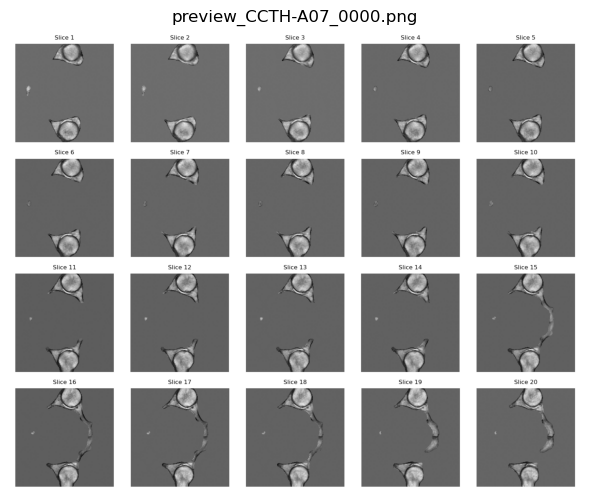

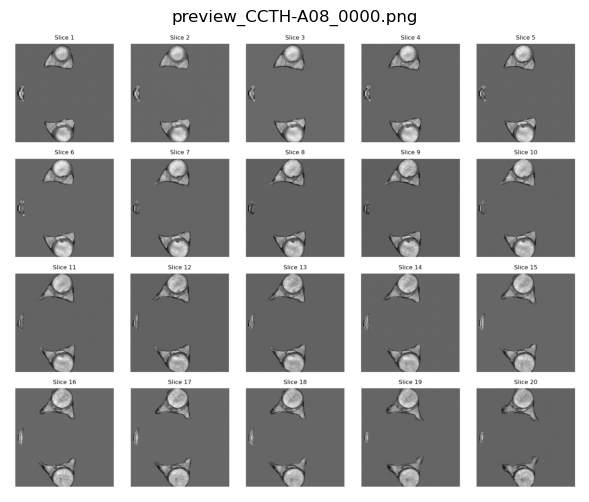

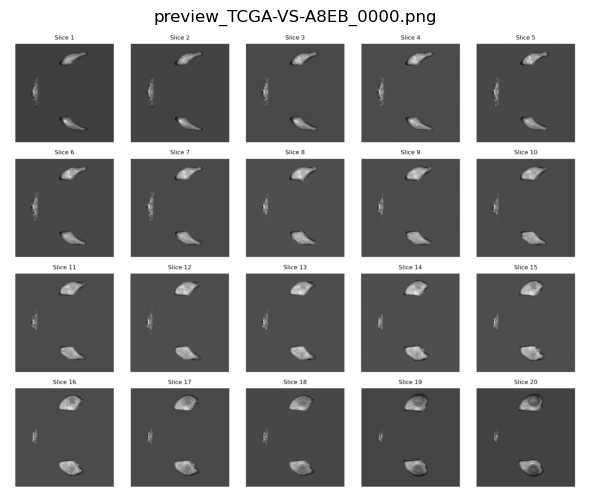

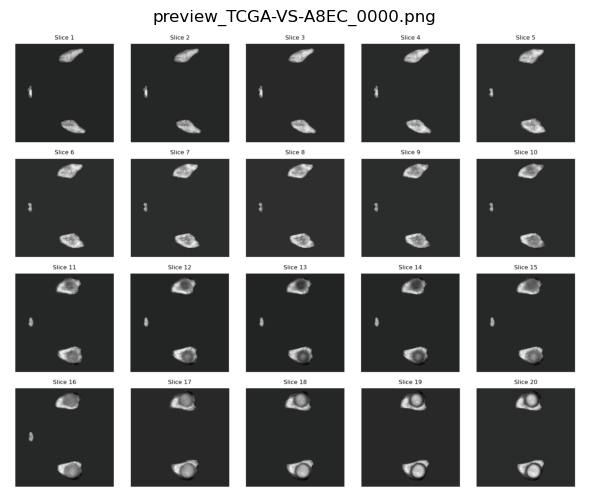

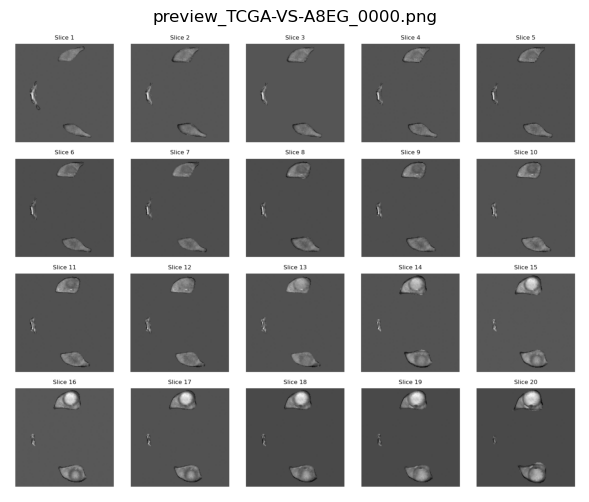

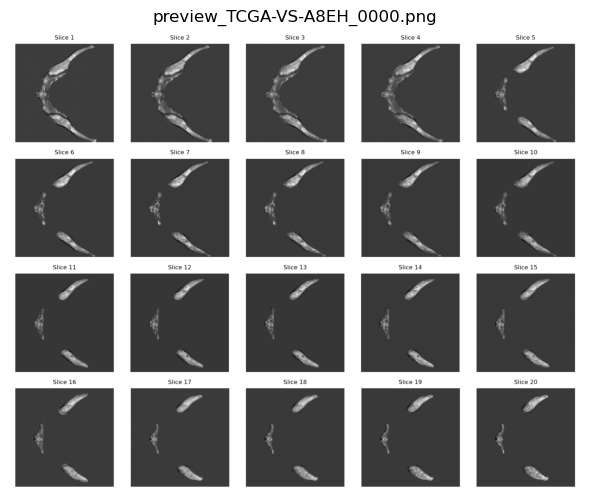

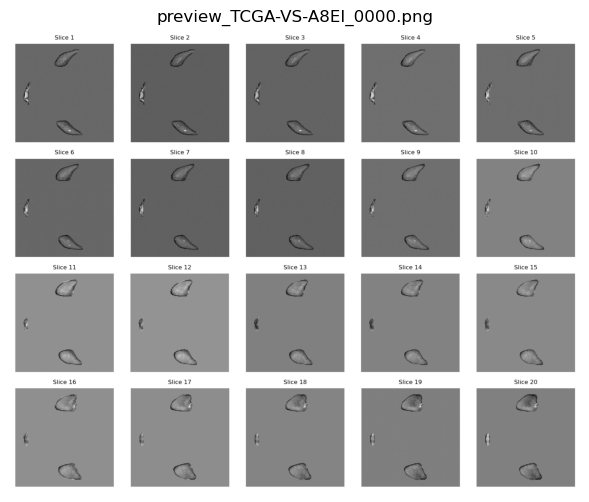

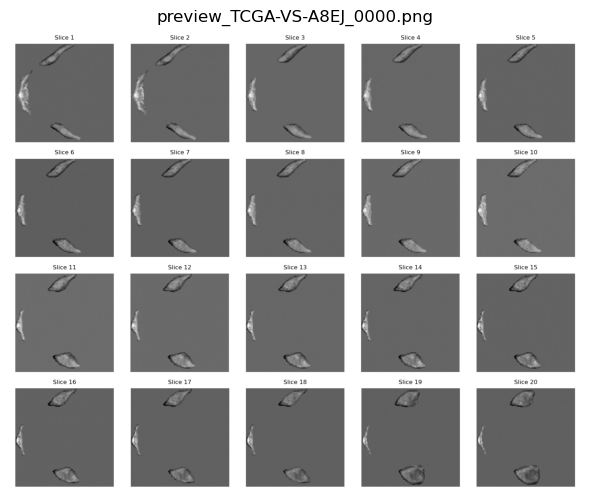

저장된 미리보기 PNG 경로 예시(최대 10개):
./slice_cache0_224/preview_CCTH-A07_0000.png
./slice_cache0_224/preview_CCTH-A08_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EB_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EC_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EG_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EH_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EI_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EJ_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EK_0000.png
./slice_cache0_224/preview_TCGA-VS-A8EL_0000.png


In [35]:
# SAVE_DIR 내 .pt 파일들 대상으로 4×5 몽타주 PNG 생성 후 화면 표시
pt_files = [f for f in os.listdir(SAVE_DIR) if f.endswith(".pt")]
pt_files = sorted(pt_files)

# 너무 많을 때는 표시 제한 (예: 최대 8명)
SHOW_MAX = 8
shown = 0
preview_paths = []

for f in pt_files:
    pid = f.replace(".pt", "")
    pt_path = os.path.join(SAVE_DIR, f)
    out_png_path = os.path.join(SAVE_DIR, f"preview_{pid}.png")
    ok = make_patient_montage(pt_path, out_png_path, cols=5)
    if ok:
        preview_paths.append(out_png_path)
        # 노트북에 인라인 표시
        if shown < SHOW_MAX:
            img = Image.open(out_png_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(os.path.basename(out_png_path))
            plt.show()
            shown += 1

print("저장된 미리보기 PNG 경로 예시(최대 10개):")
for p in preview_paths[:10]:
    print(p)
